In [1]:
from ase import io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from toolbox.calculator.elecpot import ElecPotentialCalculator
from toolbox.utils.unit import EPSILON
from toolbox import plot

In [3]:
plot.use_style("pub")

# toy model

In [4]:
l_box = 10.0  # Box length
dx = 0.01  # Grid spacing
grid_volume = 10.0 * 10.0 * dx

grids = np.arange(0.0, l_box, dx)
charge = np.zeros_like(grids)
charge[100] = 1.0
charge[-100] = -1.0
# charge density [e/A^3]
rho = charge / grid_volume

In [5]:
calculator = ElecPotentialCalculator(rho, grids)
phi = calculator.calculate(l_box=l_box)

| | FFT took 0.0016479999999998718 s
| | k-space arithmetics took 0.001827000000000023 s
| | Inverse FFT took 9.600000000009601e-05 s


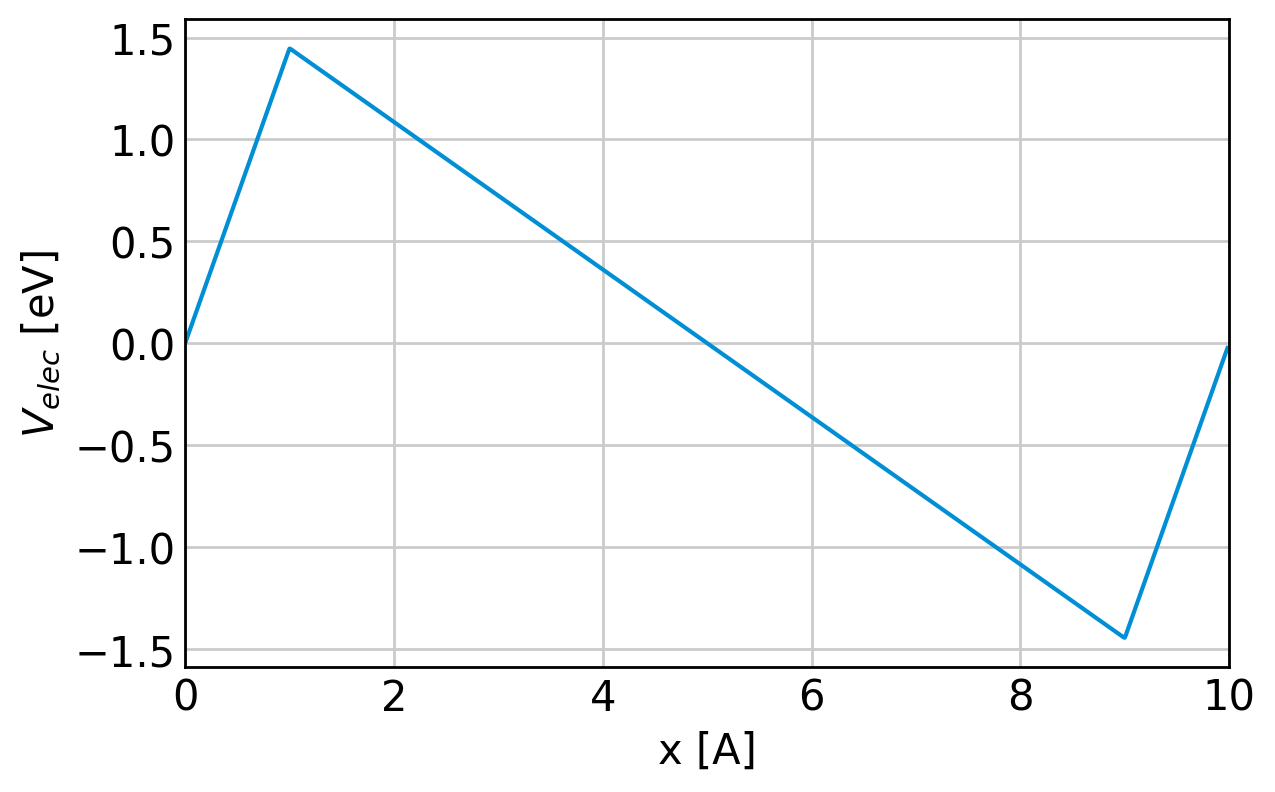

In [6]:
plt.plot(grids, phi)
plt.xlabel("x [A]")
plt.ylabel(r"$V_{elec}$ [eV]")

plt.xlim(0.0, l_box)
plt.show()

There is a dipole moment of 2 eA in the system. Consider the relationship:

$$
D=E+\varepsilon_0P
$$

and $E=0$ under periodic boundary condition, we would expect the D-field (i.e., E-field in vaccum) should be equal to the polarization field:

$$
D=\varepsilon_0P.
$$

In [7]:
dipole = 2.0
pfield = dipole / l_box**3 / EPSILON
print("The D-field from dipole moment is: %.5f [V/A]" % pfield)
lsq_out = stats.linregress(grids[200:300], phi[200:300])
print("The D-field from electrostatic profile is: %.5f [V/A]" % -lsq_out.slope)

The D-field from dipole moment is: 0.36190 [V/A]
The D-field from electrostatic profile is: 0.36190 [V/A]


# real system 

In [8]:
atoms = io.read("coord.xyz")
z = atoms.get_positions()[:, 2]
charges = atoms.get_initial_charges()
charges[atoms.symbols == "O"] = 6.0
charges[atoms.symbols == "H"] = 1.0
charges[atoms.symbols == "K"] = 9.0
charges[atoms.symbols == "F"] = 7.0
charges[atoms.symbols == "Pt"] = 0.0
charges[atoms.symbols == "X"] = -8.0
atoms.set_initial_charges(charges)

In [9]:
"""
Reference calculation
- https://github.com/SINGROUP/Potential_solver.git
"""
# from electrostatic_potential_solver import ElectrostaticPotentialSolver

# sim_cell = np.diag(atoms.cell)
# atom_coordinates = atoms.get_positions()
# atom_charges = atoms.get_initial_charges()

# # Solve electrostatic potential
# solver = ElectrostaticPotentialSolver(atom_coordinates, atom_charges, sim_cell)
# solver.set_parameter('k_cutoff', 3.0) # optimal: 3.0
# solver.set_parameter('gaussian_width', 0.5) # optimal: 0.5
# solver.set_parameter('gaussian_cutoff', 6.0) # optimal: 6.0
# solver.solve_potential()

# xs, ys, zs, pot_grid = solver.get_data_grid('potential')
# np.savetxt("potential.dat", np.transpose([zs, np.mean(pot_grid, axis=(0, 1))]))

"""
Grid parameters:
| cell_x = 16.869, cell_y = 14.609, cell_z = 41.478
| nx = 102, ny = 88, nz = 249
| dx = 0.16538235294117648, dy = 0.16601136363636362, dz = 0.16657831325301206
| kx_max = 2.964016835615626, ky_max = 2.9433910603052915, kz_max = 2.9895366218236172

| Grid initialization took 0.0012850000000002026 s
| Collocation of Gaussians to grid took 71.419461 s
| | FFT took 0.1198440000000005 s
| | k-space arithmetics took 2.1644450000000006 s
| | Inverse FFT took 0.10267600000000243 s
| Solving of the potential using FFT took 2.387240999999989 s
Total time taken to find the solution: 73.80798699999998 s
"""

'\nReference calculation\n- https://github.com/SINGROUP/Potential_solver.git\n'

In [10]:
ref_data = np.loadtxt("potential.dat")

In [11]:
l_box = atoms.get_cell()[2, 2]
dx = 1e-3  # Grid spacing
grid_volume = atoms.get_cell()[0, 0] * atoms.get_cell()[1, 1] * dx
grids = np.arange(0.0, l_box, dx)
grid_edges = np.linspace(0.0, l_box, len(grids) + 1)

_z = atoms.get_positions()[:, 2]
z = _z - l_box / 2.0
mask = z < 0.0
z[mask] += l_box
out = np.histogram(z, bins=grid_edges, weights=charges)
rho = out[0] / grid_volume

calculator = ElecPotentialCalculator(rho, grids)
phi = calculator.calculate(l_box=l_box)

| | FFT took 0.0063949999999999285 s
| | k-space arithmetics took 0.0017170000000001906 s
| | Inverse FFT took 0.005158999999999914 s


In [12]:
x = grids - l_box / 2.0
mask = x < 0.0
x[mask] += l_box
sort_ids = np.argsort(x)
x = x[sort_ids]
y = phi[sort_ids]

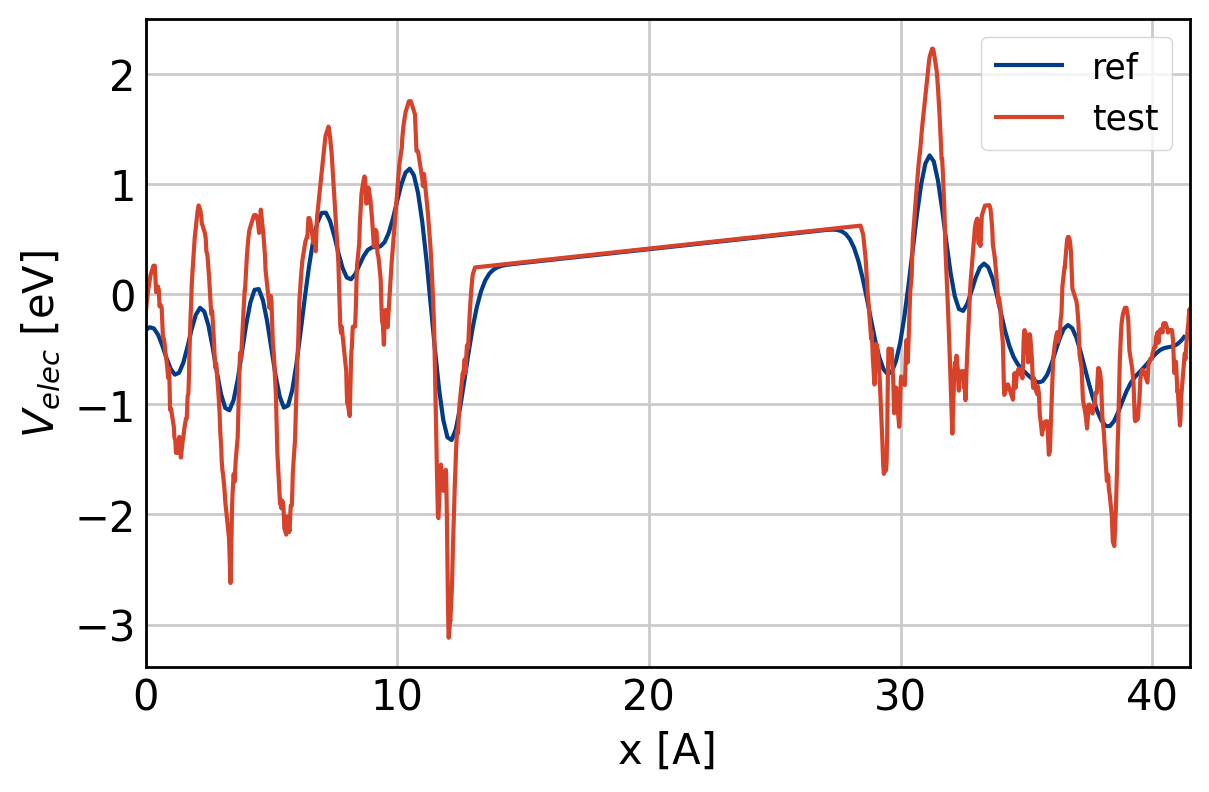

In [13]:
plt.plot(ref_data[:, 0], ref_data[:, 1], color="blue", label="ref")
plt.plot(x, y, color="red", label="test")

# x_int = x[::100]
# tck = interpolate.splrep(x, y, k=3, s=100)
# y_int = interpolate.splev(x_int, tck, der = 0)
# plt.plot(x_int, y_int, color="orange", label="test (spline)")

plt.legend()
plt.xlim(0.0, 41.478)
plt.xlabel("x [A]")
plt.ylabel(r"$V_{elec}$ [eV]")

plt.show()

In [14]:
lsq_out = stats.linregress(ref_data[:, 0][100:150], ref_data[:, 1][100:150])
print(lsq_out.slope)
lsq_out = stats.linregress(x[15000:25000], y[15000:25000])
print(lsq_out.slope)

0.024895387573892133
0.02481887220960455
